# <span style='color:purple'> Imports & settings

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import copy

PENALTY_RATE = 1
POSITION_MAPPING = {'PG':1, 'SG':2, 'SF':3, 'PF':4, 'C':5}

from roster_lib.id_dict import pid2name, name2pid, pid2pos_bref
from roster_lib.preprocessing.loader import Loader
from roster_lib.utils.colinearity_handler import ColinearityHandler
from roster_lib.clustering.pipeline import Clusterer

%reload_ext autoreload
%autoreload 2

Steps worth enriching later on :  
* duplicated entries (entries with most game played was kept, but it was also duplicated)  
* droping player missing is any of the dataset    

# <span style='color:blue'> Loader

### Duplicated handling

In [10]:
loader = Loader()
loader._load_raw_data()
for k,v in loader.raw_data.items():
    print(f"{k} - shape = {v.shape} - n° duplicated index = {v.index.duplicated().sum()}")
    # display(v.head(3))

Score - shape = (3131, 34) - n° duplicated index = 91
Misc - shape = (3066, 15) - n° duplicated index = 13
Defense - shape = (3045, 20) - n° duplicated index = 15
Pass - shape = (3092, 48) - n° duplicated index = 39
Rebound - shape = (3053, 25) - n° duplicated index = 0


In [11]:
issues = []
for k,v in loader.raw_data.items():
    for psid in v[v.index.duplicated()].index.unique():
        pid = int(psid.split('_')[0])
        sid = psid.split('_')[-1]
        if psid not in issues :
            issues.append(psid)
            print(f"{k:<12} - {pid2name[pid]:<20} - {sid} ({psid})") 

Score        - Jalen Jones          - 2017-18 (1627883_2017-18)
Score        - Delon Wright         - 2017-18 (1626153_2017-18)
Score        - Alfonzo McKinnie     - 2017-18 (1628035_2017-18)
Score        - Jakob Poeltl         - 2017-18 (1627751_2017-18)
Score        - Charles Cooke        - 2017-18 (1628429_2017-18)
Score        - ETwaun Moore         - 2017-18 (202734_2017-18)
Score        - Fred VanVleet        - 2017-18 (1627832_2017-18)
Score        - Cheick Diallo        - 2017-18 (1627767_2017-18)
Score        - Pascal Siakam        - 2017-18 (1627783_2017-18)
Score        - Darius Miller        - 2017-18 (203121_2017-18)
Score        - CJ Miles             - 2017-18 (101139_2017-18)
Score        - Jameer Nelson        - 2017-18 (2749_2017-18)
Score        - Lucas Nogueira       - 2017-18 (203512_2017-18)
Defense      - Quincy Pondexter     - 2014-15 (202347_2014-15)
Defense      - Corey Brewer         - 2017-18 (201147_2017-18)


In [13]:
# for psid in issues :
#     print(pid2name[int(psid.split('_')[0])])
#     for k,v in loader.raw_data.items():
#         if len(v.loc[psid].shape)>1 :
#             print(f"    {k}")

In [61]:
## Displays duplicated entries in "Score"

# for pl in issues :
#     print(f"{pid2name[int(pl.split('_')[0])]} - {pl.split('_')[-1]}")
#     display(data['Score'].loc[pl])

In [14]:
loader._handle_duplicated()

for k,v in loader.preproc_data.items():
    print(f"{k} - shape = {v.shape} - n° duplicated index = {v.index.duplicated().sum()}")

Score - shape = (3040, 34) - n° duplicated index = 0
Misc - shape = (3053, 15) - n° duplicated index = 0
Defense - shape = (3030, 20) - n° duplicated index = 0
Pass - shape = (3053, 48) - n° duplicated index = 0
Rebound - shape = (3053, 25) - n° duplicated index = 0


In [15]:
_tmp_list = []
partly_missing = []
for k,v in loader.preproc_data.items():
    for kk,vv in loader.preproc_data.items():
        n_missing = 0
        for id in v.index :
            if id not in vv.index:
                n_missing += 1
                if not id in partly_missing:
                    partly_missing.append(id)
        _tmp_list.append({'from': k , 'to': kk, 'missing':n_missing})
pd.DataFrame(_tmp_list).pivot(index = 'from', columns = 'to', values = 'missing')

to,Defense,Misc,Pass,Rebound,Score
from,,,,,
Defense,0,0,0,0,8
Misc,23,0,0,0,13
Pass,23,0,0,0,13
Rebound,23,0,0,0,13
Score,18,0,0,0,0


### Merging data

In [19]:
# Check if all minutes are relevant between datasets
# Impossible due to duplicate indices
_time_df = pd.concat([ v[['MIN']].rename(columns = {'MIN':k}) for k,v in loader.preproc_data.items() ], axis = 1)

_time_df['delta'] = _time_df.max(axis=1) - _time_df.min(axis = 1)
_time_df['name'] = [pid2name[int(x.split('_')[0])] for x in _time_df.index]
_time_df.sort_values('delta', ascending= False).head(10)

,Score,Misc,Defense,Pass,Rebound,delta,name
pidSzn,,,,,,,
202713_2017-18,5.0,5.0,3.3,4.9,3.3,1.7,Kyle Singler
1628451_2017-18,6.7,6.7,8.1,6.7,8.1,1.4,Jacob Wiley
201587_2019-20,23.3,23.3,22.4,23.0,22.4,0.9,Nicolas Batum
1627733_2019-20,18.1,18.1,18.7,17.8,18.7,0.9,Dragan Bender
2199_2016-17,28.0,28.0,27.3,27.6,27.3,0.7,Tyson Chandler
1627761_2017-18,17.7,17.7,18.2,17.5,18.2,0.7,DeAndre Bembry
2030_2014-15,9.6,9.6,10.2,9.5,10.2,0.7,Kenyon Martin
2555_2017-18,5.1,5.1,4.4,5.0,4.4,0.7,Nick Collison
1629627_2019-20,28.2,28.2,27.5,27.8,27.5,0.7,Zion Williamson


### Data quality

In [20]:
_dupl_df =  pd.concat([v.drop(columns = ['MIN', 'GP', 'Season']) for v in loader.preproc_data.values()], axis = 1)
n_dupl = _dupl_df.index.duplicated().sum()
n_any_na = _dupl_df.isna().any(axis = 1).sum()
print(f"n° duplicated : {n_dupl} | n° line with n.a. : {n_any_na}")

n° duplicated : 0 | n° line with n.a. : 290


In [21]:
_dupl_df.isna().sum(axis = 0).sort_values()

OFF_LOOSE_BALLS_RECOVERED      0
SCREEN_AST_PTS                 0
PAINT_TOUCH_PASSES             0
DRIVE_PF_PCT                   0
DRIVE_PF                       0
                            ... 
D_FGM                         23
FREQ                          23
OPP_PTS_FB                    23
FG2_PCT                       36
FG3_PCT                      261
Length: 127, dtype: int64

In [23]:
display(loader.preproc_data['Score'][loader.preproc_data['Score']['FG3_PCT'].isna()][['FG3A_FREQUENCY', 'FG3A','FG3_PCT']].sort_values('FG3A').head(3))
display(loader.preproc_data['Score'][loader.preproc_data['Score']['FG2_PCT'].isna()][['FG2A_FREQUENCY', 'FG2A','FG2_PCT']].sort_values('FG2A').head(3))


,FG3A_FREQUENCY,FG3A,FG3_PCT
pidSzn,,,
203945_2014-15,0.0,0.0,NaN
201582_2014-15,0.0,0.0,NaN
1905_2014-15,0.0,0.0,NaN


,FG2A_FREQUENCY,FG2A,FG2_PCT
pidSzn,,,
203958_2014-15,0.0,0.0,NaN
203479_2014-15,0.0,0.0,NaN
203925_2015-16,0.0,0.0,NaN


In [24]:
max_time = 0
for pl in partly_missing:
    for v in loader.preproc_data.values():
        if pl in v.index :
            if v.loc[pl,'MIN'] > max_time :
                max_time = v.loc[pl,'MIN']
max_time

np.float64(9.8)

In [27]:

loader.df['position'].value_counts().sort_index()

position
1.0    594
2.0    680
3.0    524
4.0    626
5.0    584
Name: count, dtype: int64

# <span style ='color:chartreuse'>ColinearityHandler

In [30]:
colinearity_handler = ColinearityHandler()

Initial number of features : 31
Top VIF = 380.2 - droping feature TS_PCT
Top VIF = 145.9 - droping feature PTS_PAINT
Top VIF = 116.9 - droping feature EFG_PCT
Top VIF = 82.1 - droping feature FG2A
Top VIF = 45.3 - droping feature FG2_PCT
Top VIF = 41.7 - droping feature USG_PCT
Top VIF = 34.5 - droping feature FG3A
Top VIF = 23.1 - droping feature PTS_OFF_TOV
Top VIF = 22.9 - droping feature PAINT_TOUCH_FG_PCT
Top VIF = 19.8 - droping feature CATCH_SHOOT_FG_PCT
Top VIF = 18.6 - droping feature PTS_2ND_CHANCE
Top VIF = 17.5 - droping feature PTS_PER_TOUCH
Top VIF = 13.0 - droping feature FG2A_FREQUENCY
Top VIF = 9.7 - stopping features exclusion with 18 feature retained
Initial number of features : 12
Top VIF = 96157.8 - droping feature DIST_MILES
Top VIF = 295.0 - droping feature DIST_MILES_OFF
Top VIF = 289.7 - droping feature AVG_SPEED
Top VIF = 141.4 - droping feature AVG_SPEED_DEF
Top VIF = 14.0 - droping feature DIST_MILES_DEF
Top VIF = 6.9 - stopping features exclusion with 7 fea

In [35]:
colinearity_handler.compute_vifs()
for k,v in colinearity_handler.vifs.items():
    print(f"Feature Selection : {k}")
    display(v.round(2).head(5))

Feature Selection : incl


,features,vif_index
42,AVG_SEC_PER_TOUCH,326.75
54,DREB_CHANCES,295.47
23,D_FG_PCT,231.05
43,AVG_DRIB_PER_TOUCH,152.08
27,OPP_PTS_PAINT,143.12


Feature Selection : excl


,features,vif_index
44,D_FG_PCT,1636.13
24,FG2A_FREQUENCY,1406.78
53,SCREEN_ASSISTS,728.40
54,SCREEN_AST_PTS,720.79
38,AVG_SPEED_DEF,692.17


Feature Selection : autoexcl


,features,vif_index
24,AVG_SPEED_OFF,103.61
71,position,31.95
27,DEF_RIM_FG_PCT,30.12
20,LOOSE_BALLS_RECOVERED,26.77
6,DRIVE_PTS,25.62


# <span style ='color:orange'> Clusterer

### <span style = 'color:chartreuse'> Results

<sopan style = 'color:cyan'>Findings and comments : </span>
* `v0` and `v1` clustering distinctions are made by Centers and Power Forwards
* `v1` introduces `penalty_score`
* `v2` tries to balance player identification by reducing statistics designed for PF and C. Only for `incl` feature selection mode
* `v3` introduces auto exclusion for features
* `v4` adds positions (before scaling and PCA) 
* `v5` introduces new `penalty_score`, with positions considered
* `v6` introduces Entropy
* `v7` introduces Pipeline, DB index and CH index


In [57]:
clusterer = Clusterer()
cdf = clusterer.load_results()
cdf['entropy_silhouette'] = cdf['entropy'] * cdf['silhouette_score']
display(cdf.sort_values(by = 'entropy_silhouette', ascending=False).head(5))
display(cdf[(cdf['n_clust']>5)&(cdf['evr']>0.7)].sort_values(by = 'entropy_silhouette', ascending=False).head(5))


,feature_selection,method,scaling,evr,n_PC,n_clust,silhouette_score,davies_bouldin,calinski_harabasz,entropy,population_std,entropy_silhouette
936,incl,kmeans,minmax,0.4,2,2,0.528339,0.808102,3134.861753,0.999609,0.011636,0.528133
988,incl,kmeans,minmax,0.5,2,2,0.528339,0.808102,3134.861753,0.999609,0.011636,0.528133
990,incl,kmeans,minmax,0.5,2,4,0.537899,0.623741,4772.518966,0.981116,0.057063,0.527742
938,incl,kmeans,minmax,0.4,2,4,0.537834,0.623755,4772.844908,0.980859,0.057438,0.527539
949,incl,agg_ward,minmax,0.4,2,2,0.525133,0.814141,3073.270843,0.999997,0.000997,0.525131


,feature_selection,method,scaling,evr,n_PC,n_clust,silhouette_score,davies_bouldin,calinski_harabasz,entropy,population_std,entropy_silhouette
1148,incl,kmeans,minmax,0.80,7,6,0.296646,1.131664,1228.067914,0.949686,0.071267,0.281720
1149,incl,kmeans,minmax,0.80,7,7,0.284426,1.129465,1146.274143,0.947028,0.065802,0.269359
1200,incl,kmeans,minmax,0.85,11,6,0.269421,1.202408,1036.199300,0.952055,0.070315,0.256504
1152,incl,kmeans,minmax,0.80,7,10,0.248975,1.193414,1051.925373,0.968408,0.038974,0.241109
1252,incl,kmeans,minmax,0.90,16,6,0.251120,1.279037,919.234149,0.950513,0.071265,0.238693


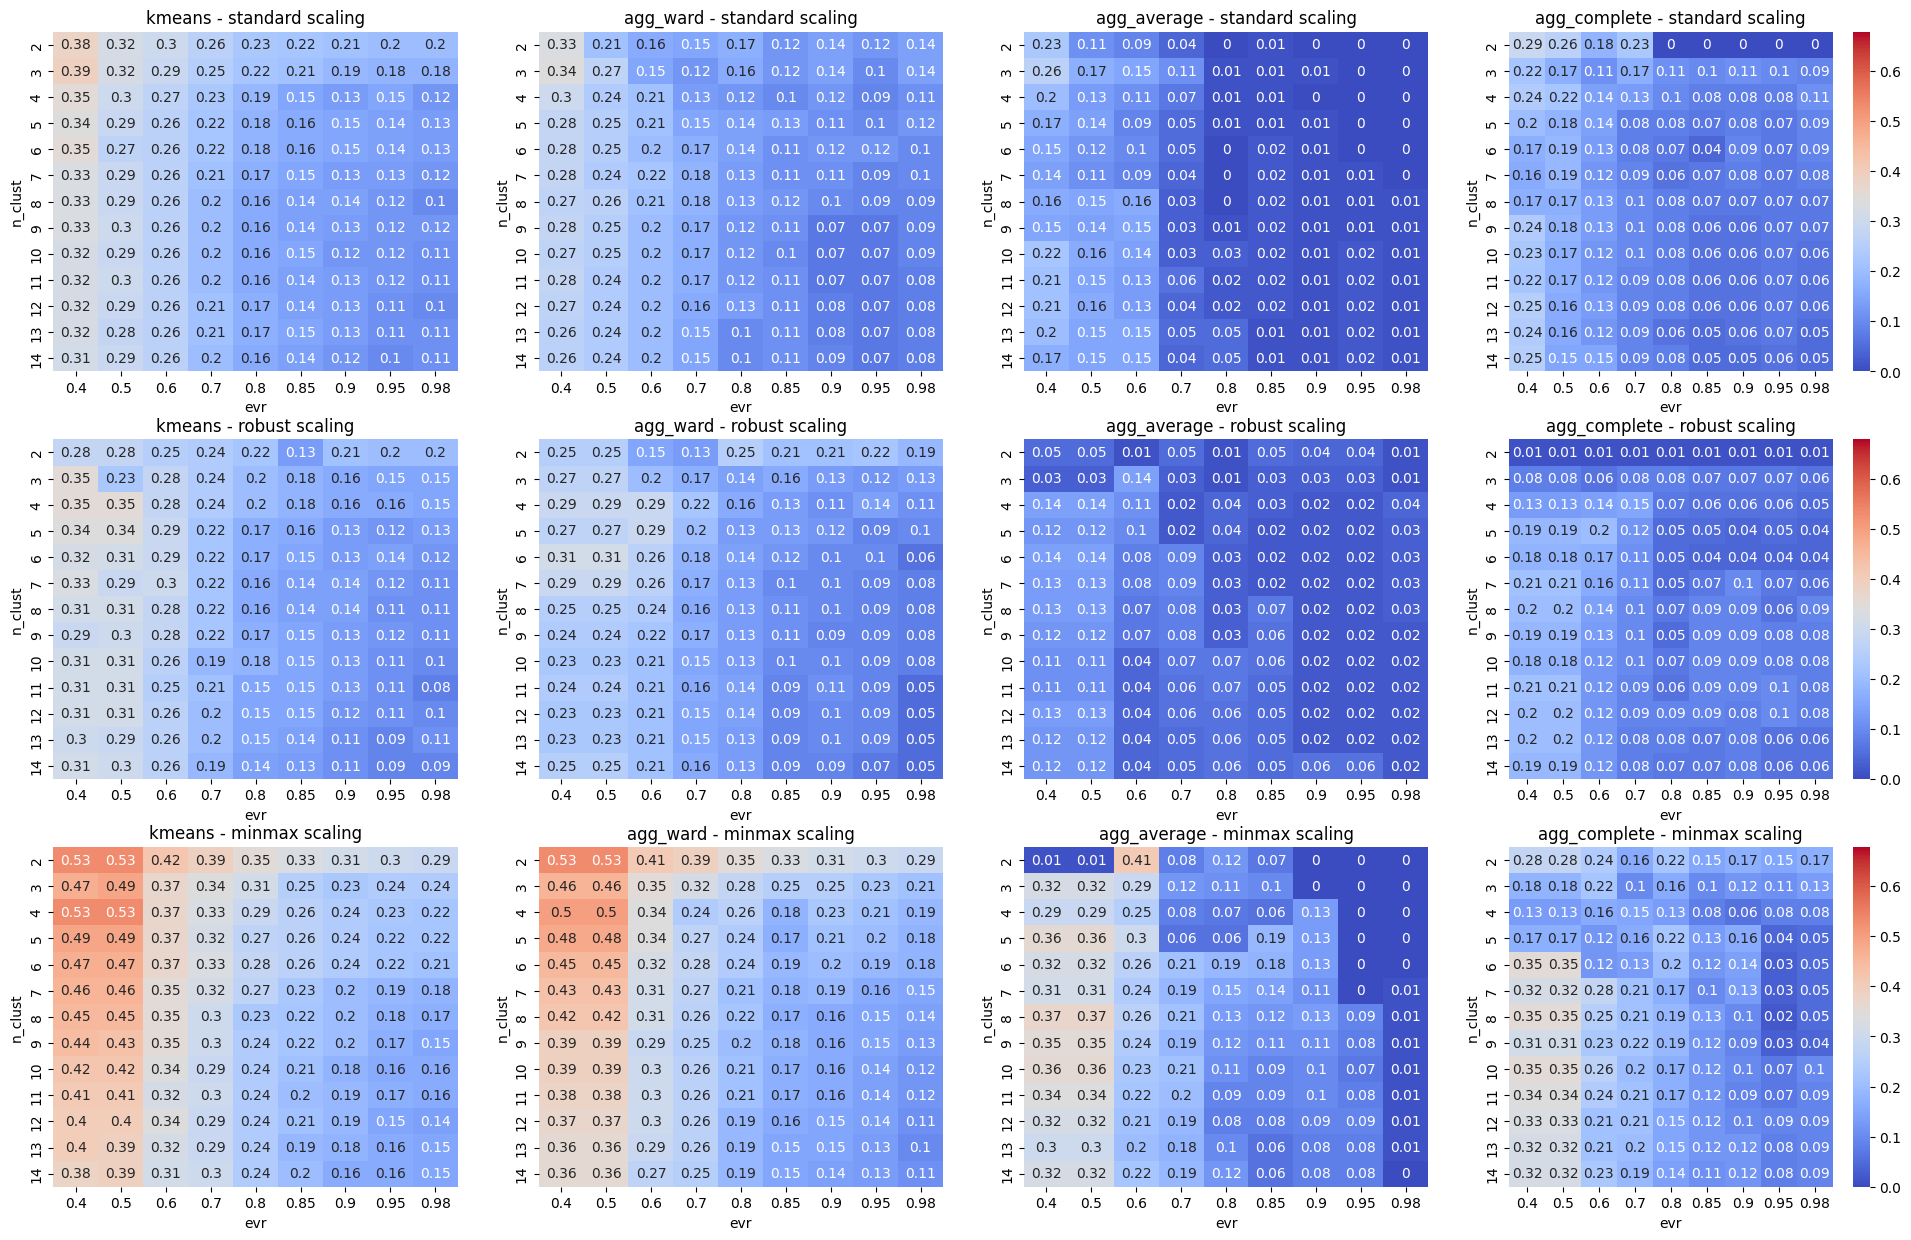

In [56]:
scalings = cdf['scaling'].unique()
methods = cdf['method'].unique()
fs = 'incl'
metric = 'entropy_silhouette'
heatmap_kw = {'cmap': 'coolwarm', 'vmin': max(cdf[metric].min()-0.15,0), 'vmax':cdf[metric].max()+0.15, 'annot': True}
fig, axs = plt.subplots(len(scalings),len(methods),figsize = (6*len(methods),5* len(scalings)));
for i, ax in enumerate(axs.flatten()) :
    method = methods[i % len(methods)]
    scaling = scalings[i // len(methods)]
    sns.heatmap(data= cdf[(cdf['method']==method)&(cdf['scaling']==scaling)&(cdf['feature_selection']==fs)].pivot(index = 'n_clust', columns = ['evr'], values = metric).round(2), 
                ax = ax, **heatmap_kw, cbar = (i % len(methods)) == len(methods) -1);
    ax.set_title(f"{method} - {scaling} scaling");


### <span style = 'color:pink'> Analysis

In [46]:
evr = 0.8
n_clust = 8
scaling = 'robust'
fs = 'incl'

_, labels_kmeans = clusterer.customized_clustering(evr = evr, n_clust = n_clust, method = 'kmeans', scaling= scaling, feature_selection= fs)
_, labels_ward = clusterer.customized_clustering(evr = evr, n_clust = n_clust, method = 'agg_ward', scaling= scaling, feature_selection= fs)
_, labels_aggavg_plus = clusterer.customized_clustering(evr = evr, n_clust = n_clust + 2, method = 'agg_average', scaling= scaling, feature_selection= fs)
_, labels_aggavg = clusterer.customized_clustering(evr = evr, n_clust = n_clust, method = 'agg_average', scaling= scaling, feature_selection= fs)
_, labels_aggavg_minus = clusterer.customized_clustering(evr = evr, n_clust = n_clust - 2, method = 'agg_average', scaling= scaling, feature_selection= fs)


Silhouette: 0.196 | Davies-Bouldin: 1.306 | Calinski-Harabasz: 804.334 | Normalized Entropy : 0.853 | Population STD: 0.098
Silhouette: 0.163 | Davies-Bouldin: 1.347 | Calinski-Harabasz: 690.203 | Normalized Entropy : 0.774 | Population STD: 0.127
Silhouette: 0.421 | Davies-Bouldin: 0.618 | Calinski-Harabasz: 248.418 | Normalized Entropy : 0.168 | Population STD: 0.271
Silhouette: 0.417 | Davies-Bouldin: 0.578 | Calinski-Harabasz: 150.052 | Normalized Entropy : 0.070 | Population STD: 0.322
Silhouette: 0.620 | Davies-Bouldin: 0.401 | Calinski-Harabasz: 184.720 | Normalized Entropy : 0.052 | Population STD: 0.366


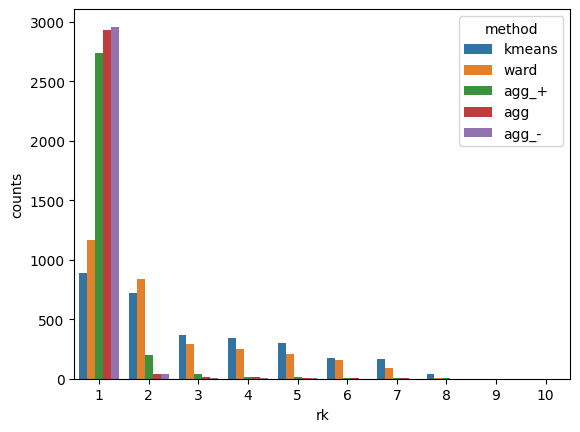

In [45]:
fig, ax = plt.subplots(1,1)
cts = []
for _labels, method in zip([labels_kmeans, labels_ward, labels_aggavg_plus, labels_aggavg, labels_aggavg_minus], ['kmeans','ward','agg_+', 'agg', 'agg_-']):
    _, counts = np.unique(_labels, return_counts= True)
    counts.sort()
    _df = pd.DataFrame(counts).rename(columns = {0:'counts'})
    _df['method'] = method
    _df['rk'] = [_df.shape[0] - x for x in _df.index]
    cts.append(_df)
_ddf = pd.concat(cts, axis = 0)
sns.barplot(data = _ddf, x = 'rk', y = 'counts', hue = 'method');


### Visual inspection 2D

Silhouette: 0.472 | Davies-Bouldin: 0.728 | Calinski-Harabasz: 2895.932 | Normalized Entropy : 0.705 | Population STD: 0.200


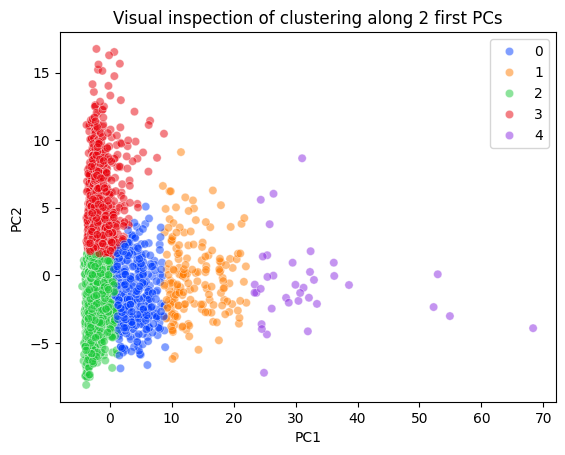

In [49]:
evr = 0.5
n_clust = 5
method = 'kmeans'
scaling = 'minmax'
feature_selection = 'incl'

X_proj, labels = clusterer.customized_clustering(evr = evr, n_clust = n_clust, method = method, scaling= 'robust', feature_selection= feature_selection)
sns.scatterplot(x = X_proj[:,0], y = X_proj[:,1], hue = labels, alpha = 0.5, palette='bright');
plt.xlabel("PC1");
plt.ylabel("PC2");
plt.title("Visual inspection of clustering along 2 first PCs");


In [51]:
cluster_df = clusterer.colinearity_handler.df.copy()
cluster_df['id'] = [int(x.split('_')[0]) for x in cluster_df.index]
cluster_df['name'] = cluster_df['id'].map(pid2name)
cluster_df['position'] = cluster_df.index.map(pid2pos_bref)
cluster_df['season'] = [x.split('_')[1] for x in cluster_df.index]
cluster_df['cluster'] = labels
cluster_df.head(3)

,EFG_PCT,TS_PCT,USG_PCT,DD2,TD3,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,PTS_PER_ELBOW_TOUCH,...,BOX_OUT_PLAYER_REBS,PCT_BOX_OUTS_OFF,PCT_BOX_OUTS_DEF,PCT_BOX_OUTS_TEAM_REB,PCT_BOX_OUTS_REB,position,id,name,season,cluster
pidSzn,,,,,,,,,,,,,,,,,,,,,
201985_2014-15,0.427,0.451,0.218,0.0,0.0,1.1,0.5,0.2,1.2,0.333,...,0.0,0.0,0.0,0.0,0.0,PG,201985,AJ Price,2014-15,2
201166_2014-15,0.495,0.534,0.246,1.0,0.0,0.8,0.6,1.1,4.3,0.464,...,0.0,0.0,0.0,0.0,0.0,PG,201166,Aaron Brooks,2014-15,3
203932_2014-15,0.478,0.517,0.151,1.0,0.0,1.3,1.0,1.1,3.2,0.643,...,0.0,0.0,0.0,0.0,0.0,PF,203932,Aaron Gordon,2014-15,2


In [52]:
cluster_df.pivot_table(index = 'cluster', columns = ['position'], values = 'id', aggfunc= 'count').fillna(0).astype(int)

position,C,PF,PG,SF,SG
cluster,,,,,
0,136,143,4,50,15
1,121,51,0,0,1
2,267,363,270,353,455
3,28,64,320,121,209
4,32,5,0,0,0


In [53]:
SMALL_CLUSTER_LIMIT = 8
small_clusters = list(cluster_df['cluster'].value_counts()[cluster_df['cluster'].value_counts()<SMALL_CLUSTER_LIMIT].index)
# cluster_df['cluster'].value_counts()

In [54]:
cluster_df[cluster_df['cluster'].isin(small_clusters)][['name','position','season','cluster']].sort_values('cluster')

,name,position,season,cluster
pidSzn,,,,


In [204]:
cluster_df[cluster_df['cluster']==1][['name','season','cluster']]

,name,season,cluster
pidSzn,,,
203458_2017-18,Alex Len,2017-18,1
203076_2017-18,Anthony Davis,2017-18,1
202687_2017-18,Bismack Biyombo,2017-18,1
202326_2017-18,DeMarcus Cousins,2017-18,1
202324_2017-18,Derrick Favors,2017-18,1
1627734_2017-18,Domantas Sabonis,2017-18,1
2730_2017-18,Dwight Howard,2017-18,1
202334_2017-18,Ed Davis,2017-18,1
202328_2017-18,Greg Monroe,2017-18,1
